In [284]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

from datetime import datetime
import glob
import rarfile
import os

import cv2

# Data loading

In [285]:
# !curl -L -k -o data.rar "https://drive.usercontent.google.com/download?id=1lJKLz3LsQmnAf9q5GGi6arEYBz-3CMhx&export=download&authuser=0&confirm=t&uuid=8b40c1cb-b956-4792-a0d5-8660e8e1777f&at=AENtkXYKKRITfP_6yrJGUvUvr7IH%3A1732475784414"

# if not os.path.exists("data/"):
#     os.makedirs("data/")

# try:
#     with rarfile.RarFile("data.rar") as rf:
#         rf.extractall(path="data/")
# except Exception as e:
#     print("Error:", e)

In [286]:
# maria
start_62 = "090652"
end_62 = "090842"
# martyna
start_71 = "092022"
end_71 = "092212"
# random
start_72 = "091752"
end_72 = "091942"
# test
start_t = "090532"
end_t = "090722"

# %%
path_out = "data_temp"
files = glob.glob(path_out + "/*")
files.sort()

dx = 5.106500953873407
dt = 0.0016


def load_df(start, end):
    start_idx = files.index(f"{path_out}\\{start}.npy")
    end_idx = files.index(f"{path_out}\\{end}.npy")

    data = []
    first_filename = files[start_idx]
    for file in files[start_idx : end_idx + 1]:
        data.append(np.load(file))
    data = np.concatenate(data)
    time_start = datetime.strptime(
        "2024-05-07 " + first_filename.split("\\")[-1].split(".")[0], "%Y-%m-%d %H%M%S"
    )
    index = pd.date_range(start=time_start, periods=len(data), freq=f"{dt}s")

    columns = np.arange(len(data[0])) * dx

    df = pd.DataFrame(data=data, index=index, columns=columns)
    return df


df62 = load_df(start_62, end_62)
df71 = load_df(start_71, end_71)
df72 = load_df(start_72, end_72)
df = df72

In [287]:
def set_axis(x, no_labels = 7)->tuple[np.array, np.array]:
    """Sets the x-axis positions and labels for a plot.

    Args:
        x (np.array): The x-axis data.
        no_labels (int, optional): The number of labels to display. Defaults to 7.

    Returns:
        tuple[np.array, np.array]: A tuple containing:
            - The positions of the labels on the x-axis.
            - The labels themselves.
    """
    nx = x.shape[0]
    step_x = int(nx / (no_labels - 1))
    x_positions = np.arange(0,nx,step_x)
    x_labels = x[::step_x]
    return x_positions, x_labels

In [288]:
def plot_image(img, a=6, b=9, lines=None, title="DataFrame Visualization", velocities=None):
    """
    Plots a DataFrame as an image with continuous coloring based on the range of values
    using normalization.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing the image data with numeric values.
    """
    # Normalize the data to the range [0, 1]
    norm = Normalize(vmin=img.min().min(), vmax=img.max().max())
    
    # Create the plot
    plt.figure(figsize=(a, b))
    plt.imshow(img, cmap='viridis', aspect='auto', norm=norm,  interpolation="none")
    
    if lines is not None:
        for i, line in enumerate(lines):
            x1, y1, x2, y2 = line[0]
            plt.plot([x1, x2], [y1, y2], color='red', linewidth=2)

            # Annotate velocity
            if velocities is not None:
                mid_x, mid_y = (x1 + x2) / 2, (y1 + y2) / 2
                plt.text(mid_x, mid_y, f"{velocities[i]:.2f} km/h", color="cyan", fontsize=15, ha="center", va="center")


    # plt.colorbar(label='Value')
    plt.title(title)
    if velocities is not None:
        plt.colorbar(label="Intensity")
        plt.xlabel("Columns (Space)")
        plt.ylabel("Rows (Time)")
        plt.axis("on")
    else:
        plt.axis('off')  # Turn off axis labels for better image representation
    # Display the plot
    plt.show()

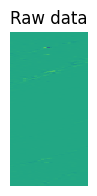

In [289]:
plot_image(df.values, a=1, b=2, title="Raw data")

In [290]:
# df = pd.DataFrame(data=data, index=index, columns=columns)
# df.shape

In [291]:
#RESIZING =>DECIMATION WITH LANCZOS INTERPOLATION❤️🦎
df = cv2.resize(df.values, (50, 1000), interpolation=cv2.INTER_LANCZOS4)
print(f"Shape of the resized df: {df.shape}")


Shape of the resized df: (1000, 50)


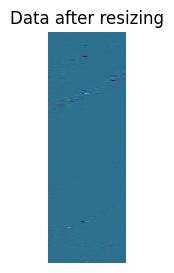

In [292]:
plot_image(df,a=1,b=3, title="Data after resizing")


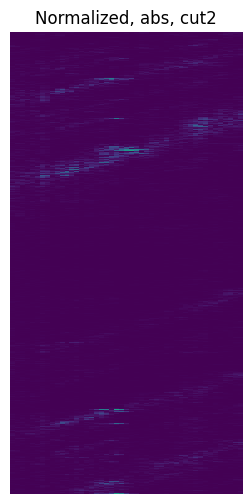

In [293]:
# df = pd.DataFrame(data=data, index=index, columns=columns)
df = pd.DataFrame(df)
df = df.iloc[:, 3:]  #DELETE FIRST 2 COLUMNS, -IT HAS NOISE, AND ITS 
#                   NOT THAT RELEVANT FOR DETECTION OF LINES❤️🦎

#ARITHMETIC OPERATIONS
df = np.abs(df)  #ABSOLUTELY NECESSARY  ❤️🦎

#NORMALIZE values to 0,255
normalized_image = cv2.normalize(df.values, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
df = pd.DataFrame(normalized_image)
plot_image(df,a=3, b=6, title="Normalized, abs, cut2")


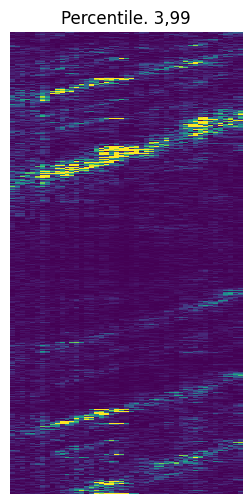

(1000, 47)


In [294]:

#CLIP PERCENTILES FOR OUTLIERS ❤️🦎 - CRUCIAL
low, high = np.percentile(df, [3,99]).astype(np.float32)
df[:] = df.apply(lambda col: np.where(((col < low)), 0, col))
df.clip(upper = high, inplace=True)

plot_image(df.values, a=3,b=6, title="Percentile. 3,99")
print(df.shape)
df_normalized = df


df_orginal = df  #NEEDED FOR FINAL VIS ❤️🦎

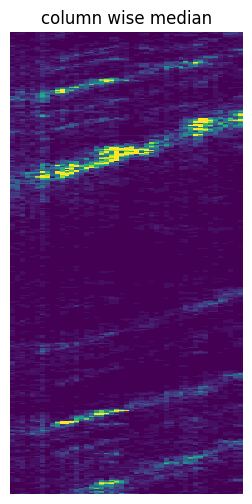

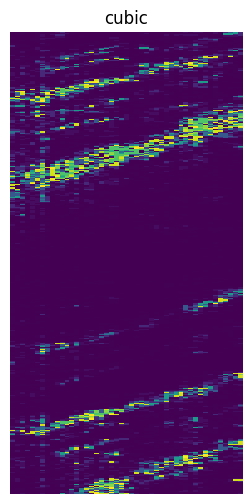

In [295]:

def column_wise_median_filter(df, kernel_size=5):
    """
    Applies a median filter to each column in the DataFrame.
    
    Parameters:
        df (pd.DataFrame): Input DataFrame.
        kernel_size (int): Size of the median filter window (must be odd).
    
    Returns:
        pd.DataFrame: Denoised DataFrame.
    """
    filtered_data = df.copy()
    
    for col in df.columns:
        filtered_data[col] = cv2.medianBlur(df[col].values.astype(np.uint8), kernel_size)
    
    return filtered_data

# Apply the median filter
df_denoised = column_wise_median_filter(df_normalized, kernel_size=5)

# Visualize the result
plot_image(df_denoised.values, a=3, b=6, title="column wise median")
df_cubic = df_denoised **3
plot_image(df_cubic.values, a=3, b=6, title="cubic")
# print(df_squared.max(axis=1))

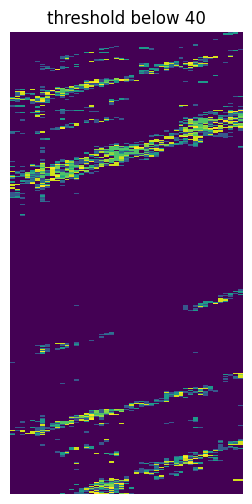

In [296]:
df_squared[:] = df_cubic.apply(lambda col: np.where(((col < 40)), 0, col))
plot_image(df_squared.values,3, 6, title="threshold below 40")

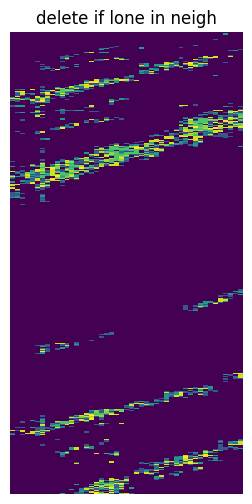

In [297]:
def set_pixel_zero_based_on_neighborhood(image, neighborhood_size=(50, 10), min_count=20):
   
    output_image = image.copy()
    h, w = image.shape
    nh, nw = neighborhood_size
    
    for y in range(h):
        for x in range(w):
            # Define the neighborhood boundaries
            y1 = max(y - nh // 2, 0)
            y2 = min(y + nh // 2 + 1, h)
            x1 = max(x - nw // 2, 0)
            x2 = min(x + nw // 2 + 1, w)
            
            # Extract the neighborhood
            neighborhood = image[y1:y2, x1:x2]
            
            # Count the number of non-zero pixels in the neighborhood
            if cv2.countNonZero(neighborhood) < min_count:
                output_image[y, x] = 0
    
    return output_image
denois = set_pixel_zero_based_on_neighborhood(df_squared.values)
plot_image(denois, 3, 6, title="delete if lone in neigh")
denois = pd.DataFrame(denois)

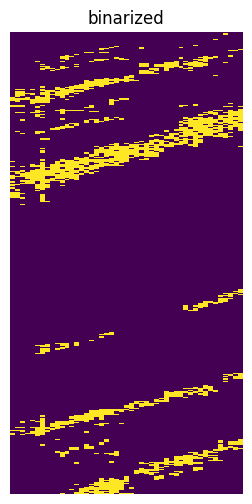

In [298]:
#BINARIZATION
df_binarized = (denois > 0).astype(int)
plot_image(df_binarized.values,a=3,b=6, title="binarized")

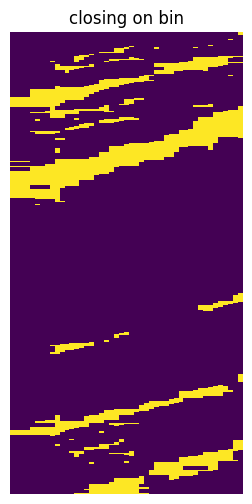

In [299]:
#CLOSING ON CANNY == CLOSING ON BINARIZED DF
    
kernel = np.ones((3, 2), np.uint8)

closed_bin = cv2.morphologyEx(df_binarized.values.astype(np.uint8), cv2.MORPH_CLOSE, kernel, iterations=3)
plot_image(closed_bin, 3, 6, title="closing on bin")

# edges_closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel, iterations=3)
# plot_image(edges_closed_bin, 3, 6, title="closing ")

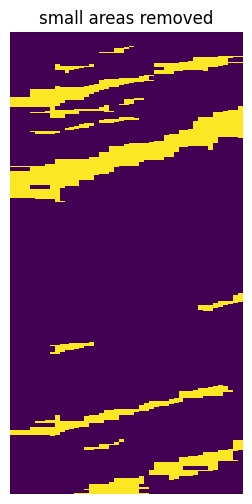

In [300]:
def remove_small_areas(binary_image, min_area=100):
    num_labels, labels = cv2.connectedComponents(binary_image)
    output_image = np.zeros_like(binary_image, dtype=np.uint8)
    
    for label in range(1, num_labels):
        region = (labels == label).astype(np.uint8)
        if cv2.countNonZero(region) >= min_area:
            output_image[region == 1] = 255
    
    return output_image

remove_small = remove_small_areas(closed_bin, 30)
plot_image(remove_small, 3,6,title="small areas removed")

<!-- -------
-------
------- -->

In [301]:
# def plot_connected_components(binary_image):
#     # Find connected components and their labels
#     num_labels, labels = cv2.connectedComponents(binary_image)

#     # Plot each connected component separately
#     for label in range(1, num_labels):  # Start from 1 to skip the background
#         region = (labels == label).astype(np.uint8) * 255  # Extract the region and scale to 255
#         plot_image(region, 1,2)
# plot_connected_components(remove_small)


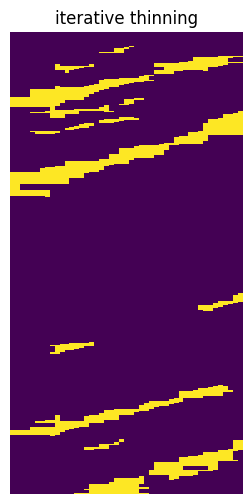

In [302]:
def erode_wide_lines(binary_image, min_line_width=5, kernel_size=3, iterations=1):
    num_labels, labels = cv2.connectedComponents(binary_image)
    mask = np.zeros_like(binary_image, dtype=np.uint8)
    
    for label in range(1, num_labels):
        region = (labels == label).astype(np.uint8)
        if cv2.countNonZero(region) >= min_line_width:
            mask[region == 1] = 1
    
    kernel = np.ones((5,3), np.uint8)
    eroded_image = cv2.erode(binary_image, kernel, iterations=iterations)
    result_image = np.where(mask == 1, eroded_image, binary_image)
    result_image = (result_image * 255).astype(np.uint8)
    
    return result_image

# Example usage
iterative_thinning = erode_wide_lines(remove_small, min_line_width=2500, kernel_size=3, iterations=2)
plot_image(iterative_thinning, 3, 6, title="iterative thinning")

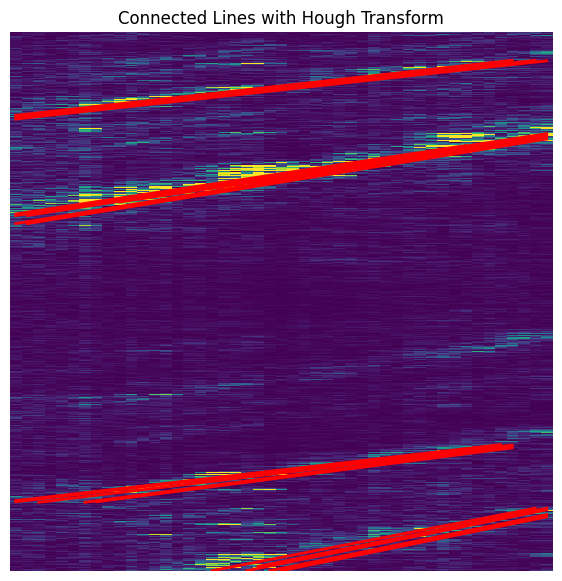

In [303]:
lines = cv2.HoughLinesP(iterative_thinning, rho=1, theta=np.pi / 180, threshold=5, minLineLength=100, maxLineGap=25)
plot_image(df_orginal.values, a=7, b= 7, lines = lines, title="Connected Lines with Hough Transform")


[[[0, 154, 46, 53]], [[0, 337, 46, 198]], [[0, 869, 43, 771]], [[17, 999, 46, 899]]]


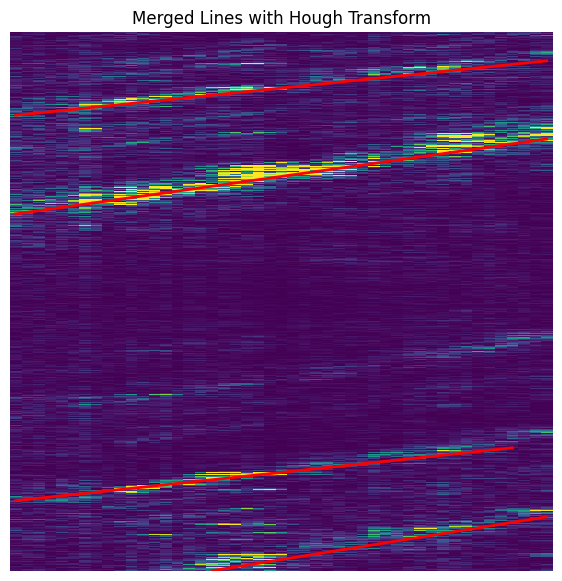

In [304]:
def merge_lines(lines, min_distance=30, max_angle_diff=25):
    """
    Groups lines that are close together and have similar angles, then selects
    the line with the most left and most right coordinates in each group.

    Parameters:
    lines (list): List of lines detected by HoughLinesP (x1, y1, x2, y2).
    min_distance (float): Minimum distance to consider two lines as part of the same group.
    max_angle_diff (float): Maximum angle difference (in degrees) to group lines.

    Returns:
    list: A list of selected lines represented as [[[x1, y1, x2, y2]], ...].
    """
    if lines is None or len(lines) == 0:
        return []

    merged_groups = []

    for line in lines:
        x1, y1, x2, y2 = line[0]
        if x1 == x2:
            continue
        angle = np.degrees(np.arctan2(y2 - y1, x2 - x1))
        length = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)  # Calculate line length
        midpoint = ((x1 + x2) / 2, (y1 + y2) / 2)  # Calculate midpoint
        added = False

        for group in merged_groups:
            gx1, gy1, gx2, gy2, gangle, glines = group
            group_midpoint = ((gx1 + gx2) / 2, (gy1 + gy2) / 2)
            group_distance = np.sqrt(
                (midpoint[0] - group_midpoint[0]) ** 2
                + (midpoint[1] - group_midpoint[1]) ** 2
            )

            if group_distance < min_distance and abs(gangle - angle) < max_angle_diff:
                # Add the line to this group
                group[0] = min(gx1, x1, x2)  # Update group boundaries
                group[1] = min(gy1, y1, y2)
                group[2] = max(gx2, x1, x2)
                group[3] = max(gy2, y1, y2)
                group[4] = (gangle + angle) / 2  # Average the angles
                group[5].append((x1, y1, x2, y2))  # Add line coordinates
                added = True
                break

        if not added:
            # Create a new group for this line
            merged_groups.append([x1, y1, x2, y2, angle, [(x1, y1, x2, y2)]])

    # Select the line with the most left and most right coordinates from each group
    selected_lines = []
    for group in merged_groups:
        group_lines = group[5]  # All lines in the group

        # Determine the overall leftmost and rightmost points
        leftmost = min((line[0], line[1]) for line in group_lines)
        rightmost = max((line[2], line[3]) for line in group_lines)

        # Form a new line from the leftmost to the rightmost point
        selected_lines.append([[leftmost[0], leftmost[1], rightmost[0], rightmost[1]]])
    return selected_lines

merged_lines = merge_lines(lines)
print(merged_lines)
# Plot merged lines
plot_image(df_orginal.values, a= 7, b= 7, lines = merged_lines, title="Merged Lines with Hough Transform")

In [305]:
#FAJNY KOD DO USTAWIENIA DX I DT

# Original values
original_dx = 5.106500953873407
original_dt = 0.0016
original_shape = (75000, 52)  # (rows, columns)

# New dataframe shape
new_shape = df.shape  # (rows, columns)

# Calculate new dx and dt
new_dt = original_dt * (original_shape[0] / new_shape[0])
new_dx = original_dx * (original_shape[1] / new_shape[1])

print(f"New dx: {new_dx:.3f} meters/column")
print(f"New dt: {new_dt:.3f} seconds/row")


New dx: 5.650 meters/column
New dt: 0.120 seconds/row


In [306]:
def calculate_velocities(lines, dx, dt):
    """
    Calculate velocities for each line based on its slope.

    Parameters:
        lines (list): List of merged lines in the format [[[x1, y1, x2, y2]], ...].
        dx (float): Spatial resolution (distance per column).
        dt (float): Temporal resolution (time per row).

    Returns:
        list: A list of velocities corresponding to each line.
    """
    velocities = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        if x2 != x1:  # Avoid division by zero
            slope = (y2 - y1) / (x2 - x1)  # Slope in pixels
            velocity = abs(dx / (slope * dt)) * 3.6  # Convert to km/h
            velocities.append(velocity)
        else:
            velocities.append(None)  # Vertical line: undefined velocity
    return velocities

velocities = calculate_velocities(merged_lines, new_dx, new_dt)
print(velocities)




[77.19454570253966, 56.09100083421945, 74.36910203773951, 49.15278790494318]


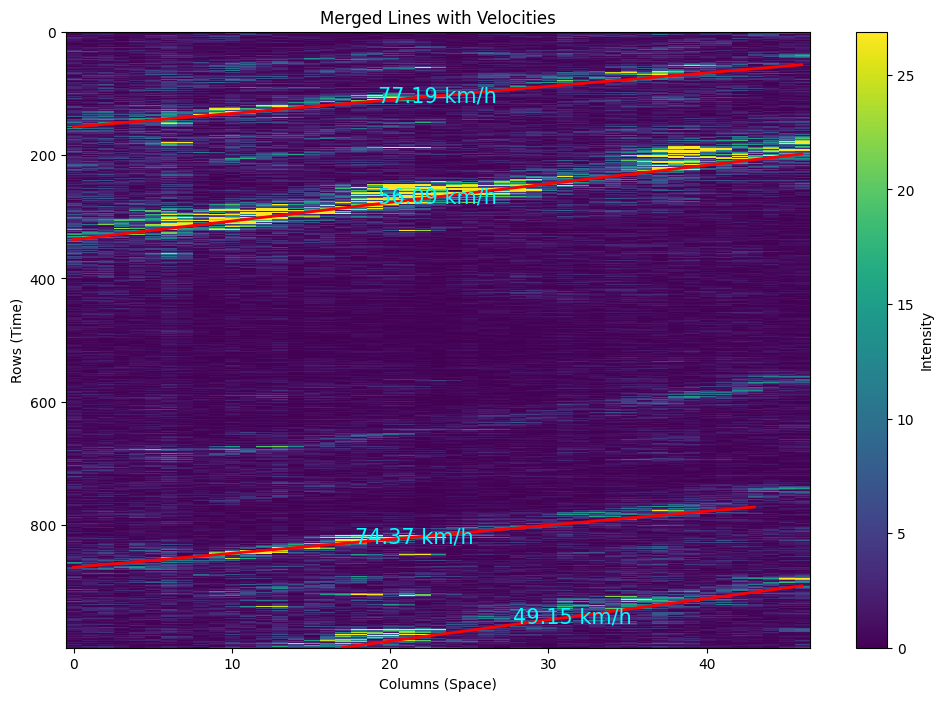

In [307]:
plot_image(df_orginal, a=12,b=8,lines=merged_lines, title="Merged Lines with Velocities",velocities=velocities)

# Clustering sandbox


In [308]:
from skimage import measure
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.feature import canny
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

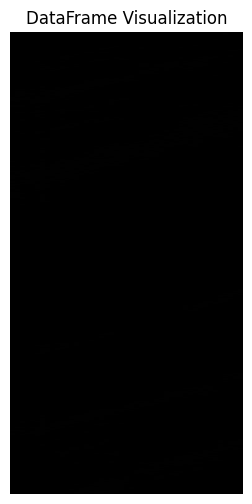

In [309]:
import cv2
import numpy as np

# Load the binary image
image = df_binarized.values.astype(np.uint8)

# Apply Gaussian blur to reduce noise
# smoothed_image = cv2.GaussianBlur(image, (5, 5), 0)

# Use Canny edge detection to detect the edges
edges = cv2.Canny(image, 50, 150)

# Find contours in the image
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on the image
contour_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)

plot_image(contour_image,3,6)



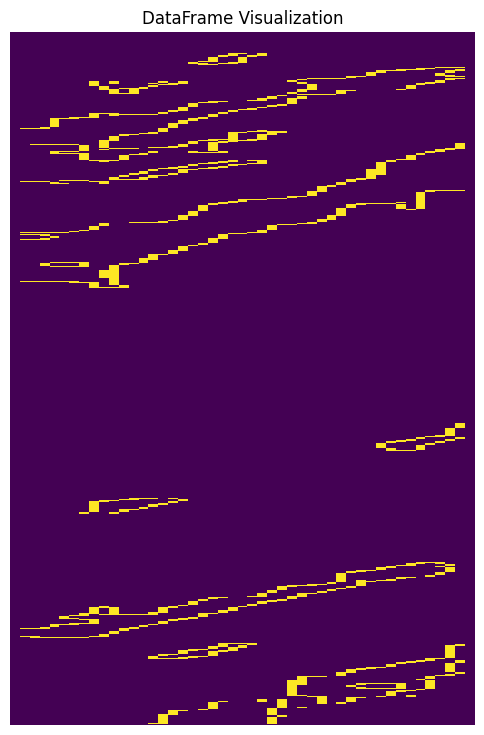

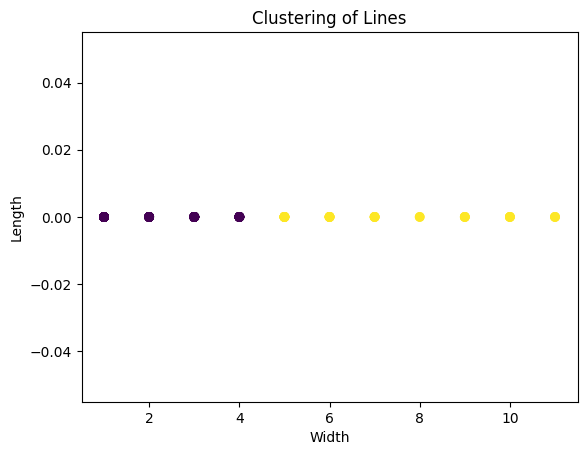

In [310]:


# Load the binary image
image = remove_small  # replace with your image path
gray_image = rgb2gray(image) if len(image.shape) == 3 else image

# Thresholding to ensure binary format
thresh = threshold_otsu(gray_image)
binary_image = gray_image > thresh

# Edge detection using Canny
edges = canny(binary_image)
plot_image(edges)
# Find contours in the image
contours = measure.find_contours(edges, 0.5)

# Extract features (width and length)
features = []
for contour in contours:
    # Calculate width and length
    min_row, min_col = np.min(contour, axis=0).astype(int)
    max_row, max_col = np.max(contour, axis=0).astype(int)
    length = np.linalg.norm(contour[-1] - contour[0])
    width = max_col - min_col
    features.append([width, length])

# Convert features to a numpy array
features = np.array(features)

# Apply K-means clustering
kmeans = KMeans(n_clusters=2)  # Choose the number of clusters as needed
kmeans.fit(features)

# Visualize the clusters
plt.scatter(features[:, 0], features[:, 1], c=kmeans.labels_)
plt.xlabel('Width')
plt.ylabel('Length')
plt.title('Clustering of Lines')
plt.show()


In [311]:
# from skimage.measure import label, regionprops

# # plot_image(remove_small)
# labels = label(denois.values)

# # Extract region properties for detected objects
# regions = regionprops(labels)


# type_of_lines = []
# features = []

# for region in regions:
#     print(region.area)
#     x1, y1, x2, y2 = region.bbox
#     type_of_lines.append(region.axis_minor_length)
#     features.append([x1, y1, x2, y2])
#     # reg = np.zeros_like(remove_small)
#     # separate = region.image
#     # part = region.slice
#     # reg[part] = 1
#     # plot_image(reg,1,2)
    
    
# print(features)
    
    

# # Visualize labeled regions
# fig = plt.figure(figsize=(3, 4))
# ax = plt.axes()

# im = ax.imshow(labels, interpolation='none', aspect='auto', cmap='tab20')
# plt.ylabel('time')
# plt.xlabel('space [m]')

# cax = fig.add_axes([ax.get_position().x1 + 0.06, ax.get_position().y0, 0.02, ax.get_position().height])
# plt.colorbar(im, cax=cax)


# x_positions, x_labels = set_axis(df.columns)
# ax.set_xticks(x_positions, np.round(x_labels, 1))
# y_positions, y_labels = set_axis(df.index.time)
# ax.set_yticks(y_positions, y_labels)

# plt.show()


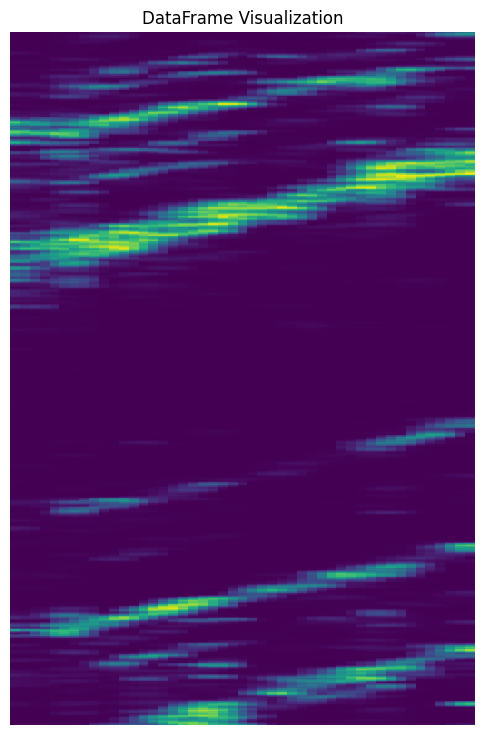

[  21   40   74 8157   13   24   23  387   15   11   26  421   12   25
   16 4415   75   20   26   36   13]


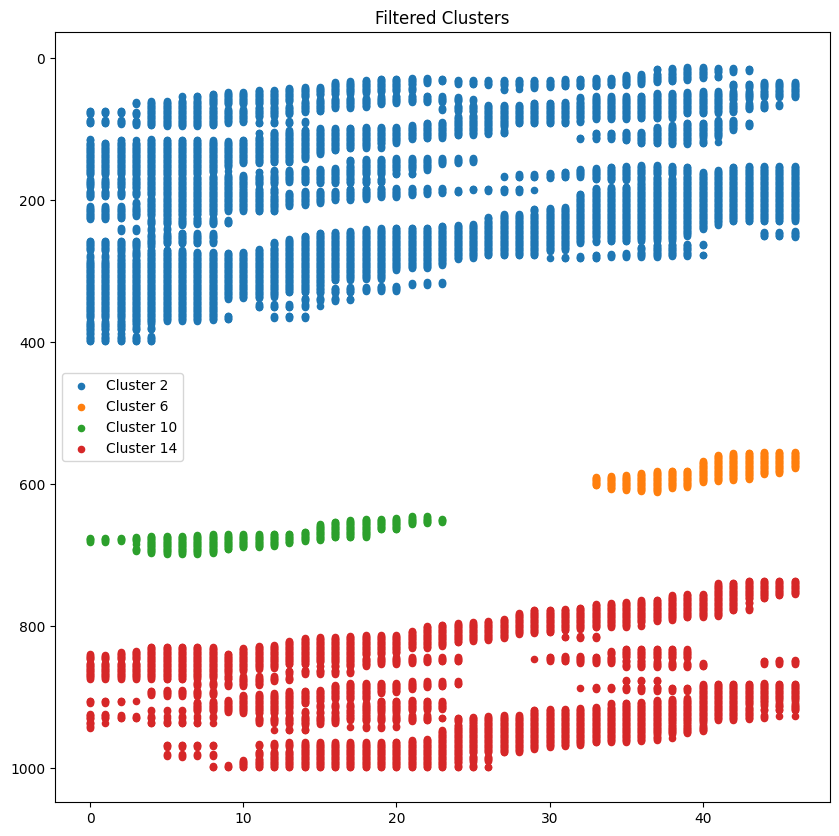

In [312]:
import cv2
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

ga = cv2.GaussianBlur(df_cubic.values, (5,5), 2)
plot_image(ga)
binary_image = ga
_, binary_image = cv2.threshold(binary_image, 5, 255, cv2.THRESH_BINARY)
coordinates = np.column_stack(np.where(binary_image > 0))


db = DBSCAN(eps=5, min_samples=10).fit(coordinates)
labels = db.labels_


unique_labels, counts = np.unique(labels, return_counts=True)
print(counts)
large_cluster_labels = unique_labels[counts >= 150]

# Keep only points in large clusters
filtered_coordinates = np.array([
    point for point, label in zip(coordinates, labels)
    if label in large_cluster_labels
])

# Visualize the filtered clusters
plt.figure(figsize=(10, 10))
for cluster_id in large_cluster_labels:
    cluster_points = coordinates[labels == cluster_id]
    plt.scatter(cluster_points[:, 1], cluster_points[:, 0], s=20, label=f"Cluster {cluster_id}")

plt.gca().invert_yaxis()  # To match image coordinates
plt.legend()
plt.title("Filtered Clusters")
plt.show()


can cluster based on length, intensity//area. we should additionally work on velocities.